Forecasting electricity demand is an extremely relevant problem for energy providers, as it influences not only the cost of day to day operations but also the timeliness and effectiveness of preparing for extreme weather conditions. Additionally, providers have to account for variations in geographic locations, further increasing the complexity of forecasting tasks. 

In this blog post, I aim to explore the applications and performance of several forecasting methods for this task. I'm specifically using the Australian New South Wales Electricity Market dataset, which features the electricity price and demand of New South Wales and Victoria, as well as the amount transferred between the two states.

The data contains 45,312 instances for the days from May 7, 1996 to December 5, 1998, with observations recorded every half hour in each 24 hour period. I account for this granularity in my approach.

In [31]:
#| echo: false
#| label: library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
from sktime.utils.plotting import plot_series
from sktime.transformations.series.detrend import Deseasonalizer

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [17]:
#| echo: false
#| cache: true
#| label: read and process data

electricity = pd.read_csv("C:/Users/jrh25/Desktop/personal-site/data/electricity.csv")
electricity['day'] = electricity['day'].str.replace("b'", "").str.replace("'", "")
electricity['class'] = electricity['class'].str.replace("b'", "").str.replace("'", "")

In [18]:
#| echo: true

electricity.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN


The data has a very fine level of granularity, making for a highly dense time series plot for the entire series. Right off the bat we can observe a longer term seasonality in the trend line of the graph.

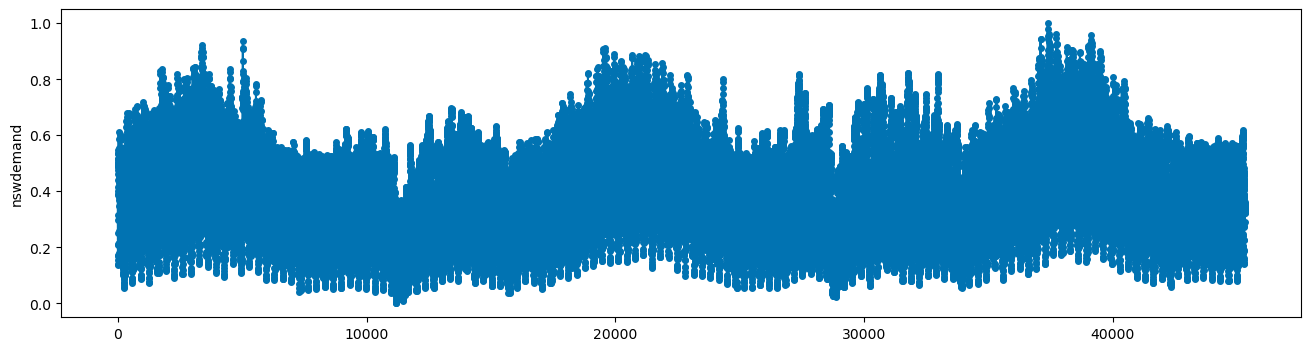

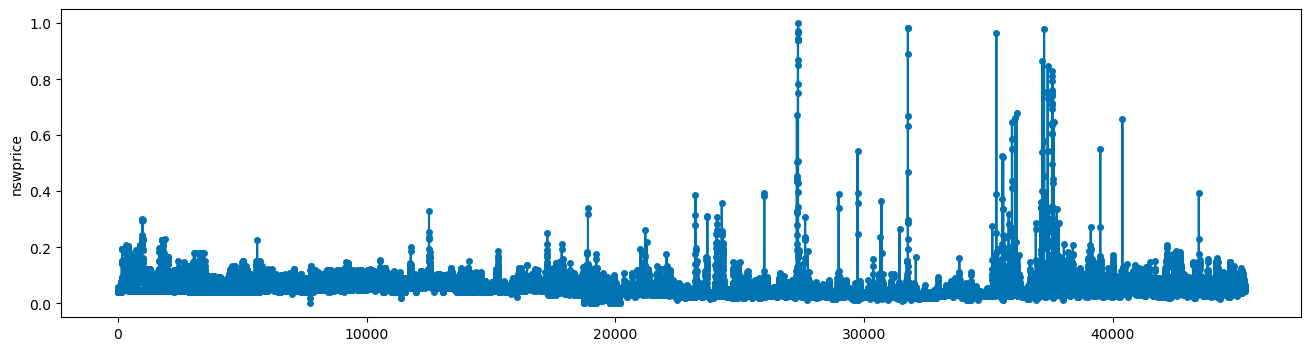

In [24]:
fig, ax = plot_series(electricity['nswdemand'])
fig, ax = plot_series(electricity['nswprice'])

Plotting a couple smaller length sections of the series (in intervals of 1000 observations) lets us see smaller scale seasonalities, which are immediately discernable.

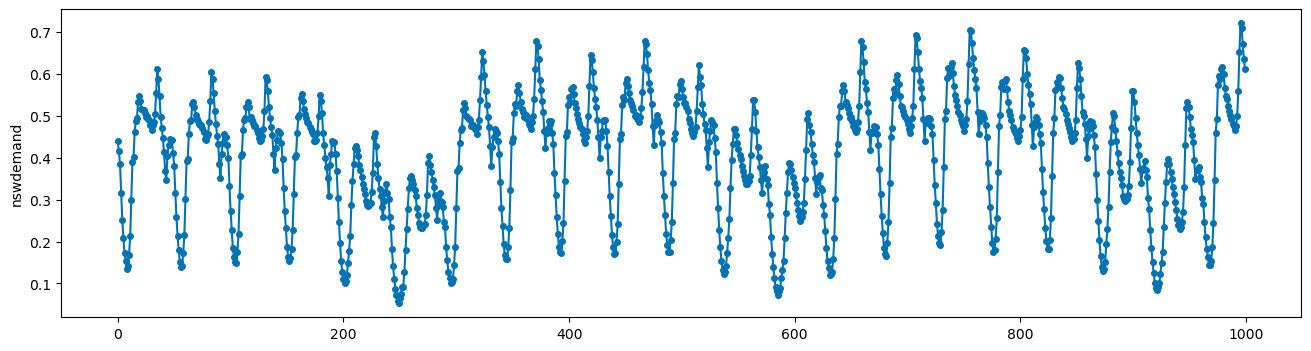

In [28]:
fig, ax = plot_series(electricity['nswdemand'][0:1000])

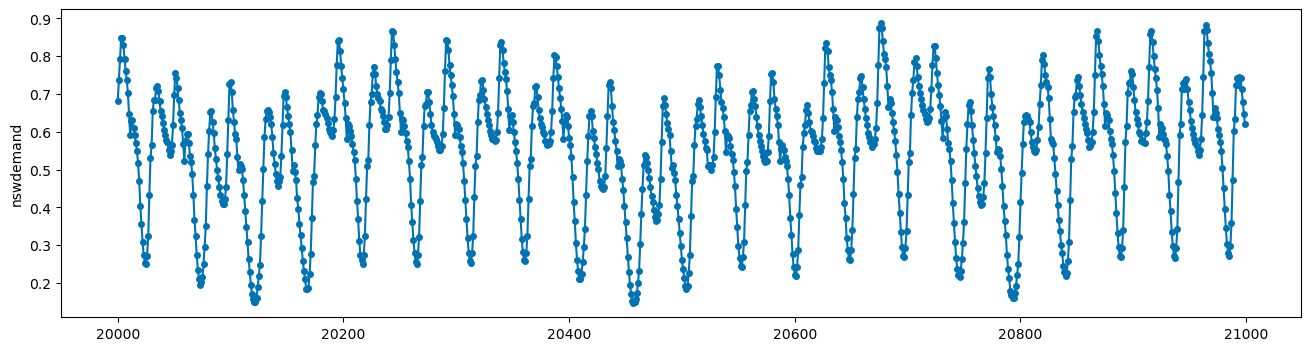

In [29]:
fig, ax = plot_series(electricity['nswdemand'][20000:21000])

The magnitude of seasonal variations doesn't appear to be influenced by the length of the time series, so I assume an additive decomposition to be the most appropriate such that

$y_t = S_t + T_t + R_t$

where data is decomposed into seasonal, trend, and remainder components respectively.

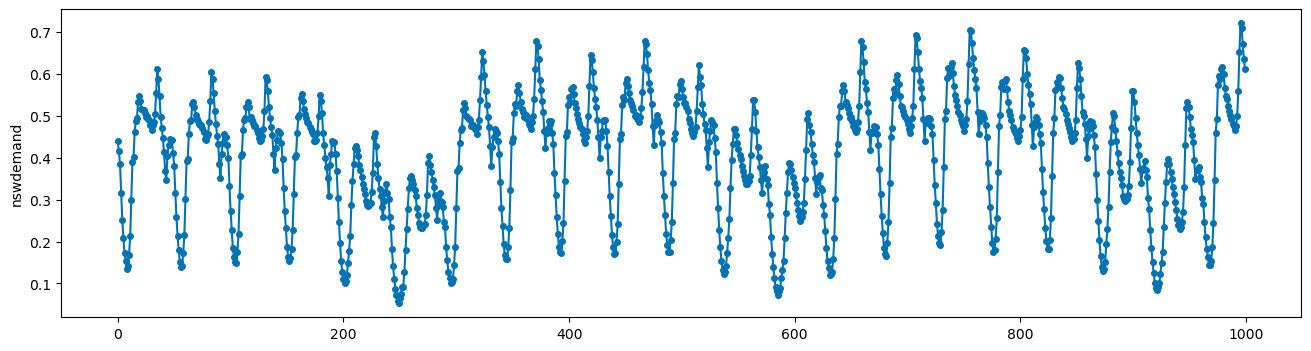

In [43]:
transformer = Deseasonalizer(model='additive')
decomposed = transformer.fit_transform(electricity['nswdemand'][0:1000])
fig, ax = plot_series(decomposed)

0       0.439155
1       0.415055
2       0.385004
3       0.314639
4       0.251116
          ...   
9995    0.098929
9996    0.124665
9997    0.165427
9998    0.215412
9999    0.250967
Name: nswdemand, Length: 10000, dtype: float64